In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import statsmodels.api as sm
import numpy as np
from sklearn.metrics import root_mean_squared_error

# Set Seaborn style
sns.set(style='whitegrid')

# Define paths
RAW_DIR = Path("../data/raw")
MATLAB_DIR = Path("../src/matlab")

In [2]:
import os
import sys
# Add the 'src' folder to the Python path so project-specific modules can be imported
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "src")))


In [20]:
# ---- Load IPCA (Inflation) ----
ipca_raw = pd.read_csv(RAW_DIR / "IBGE_20250331_183405_T118-V306_205037.csv")
ipca_two = pd.read_csv(MATLAB_DIR / "ipca_trend_two_sided.csv", header=None, names=["trend_two"])
ipca_one = pd.read_csv(MATLAB_DIR / "ipca_trend_one_sided.csv", header=None, names=["trend_one"])

ipca = ipca_raw.copy()
ipca["trend_two"] = ipca_two["trend_two"]
ipca["trend_one"] = ipca_one["trend_one"]

# --- Load GDP ---
gdp_raw = pd.read_csv(RAW_DIR / "IBGE_20250331_183405_T6613-V9319_205007.csv")
gdp_two = pd.read_csv(MATLAB_DIR / "gdp_trend_two_sided.csv", header=None, names=["trend_two"])
gdp_one = pd.read_csv(MATLAB_DIR / "gdp_trend_one_sided.csv", header=None, names=["trend_one"])

gdp = pd.DataFrame()
gdp["log_valor"] = np.log(gdp_raw["valor"])
gdp["trend_two"] = gdp_two["trend_two"]
gdp["trend_one"] = gdp_one["trend_one"]

# --- Apply BK Filter to log-GDP (remove trend, isolate cycle) ---
# Set min/max periods in quarters (e.g., 6 to 32 → 1.5 to 8 years)
bk_cycle = sm.tsa.filters.bkfilter(gdp["log_valor"], low=6, high=32, K=12)
bks_cycle = sm.tsa.filters.bkfilter(gdp["log_valor"], low=6, high=32, K=40)

# Extract trend by subtracting the cycle from the original
gdp["bk_trend"] = gdp["log_valor"] - bk_cycle
gdp["bks_trend"] = gdp["log_valor"] - bks_cycle


In [4]:
# --- Apply Python HP Filter ---
_, ipca_trend_py = sm.tsa.filters.hpfilter(ipca["valor"], lamb=129600)
_, gdp_trend_py  = sm.tsa.filters.hpfilter(gdp["log_valor"], lamb=1600)

# --- Compute RMSE ---
ipca_rmse = root_mean_squared_error(ipca["trend_two"], ipca_trend_py)
gdp_rmse  = root_mean_squared_error(gdp["trend_two"], gdp_trend_py)

# --- Print Results ---
print(f"RMSE between MATLAB and Python trends:")
print(f"- IPCA trend (percent):       {ipca_rmse:.6f}")
print(f"- GDP trend (log of level):   {gdp_rmse:.6f}")


RMSE between MATLAB and Python trends:
- IPCA trend (percent):       0.000000
- GDP trend (log of level):   0.000000


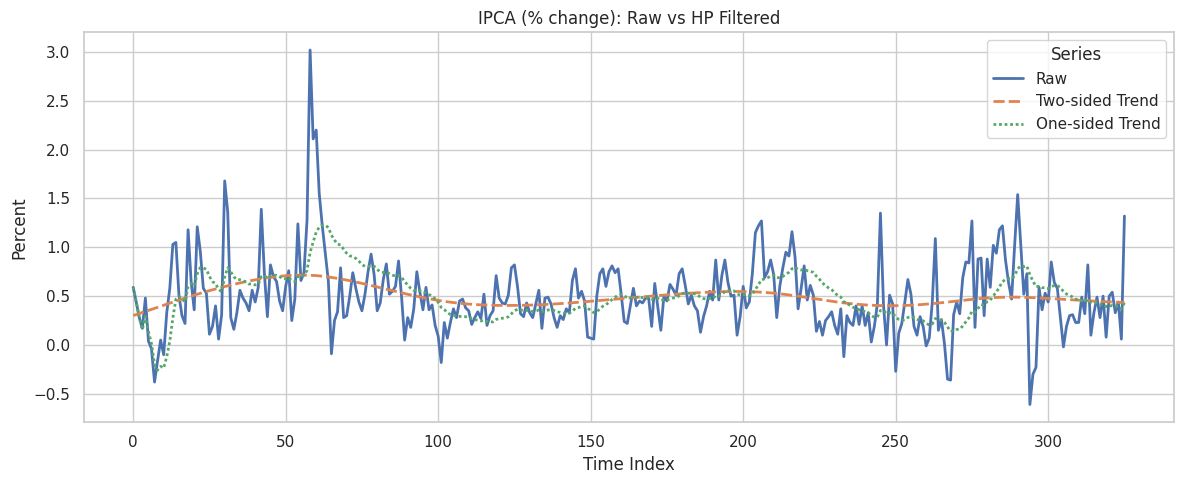

In [5]:
# Melt data for Seaborn
ipca_plot = ipca[["valor", "trend_two", "trend_one"]].copy()
ipca_plot.columns = ["Raw", "Two-sided Trend", "One-sided Trend"]
ipca_plot = ipca_plot.reset_index().melt(id_vars="index", var_name="Series", value_name="Value")

# Plot using default style and palette
plt.figure(figsize=(12, 5))
sns.lineplot(data=ipca_plot, x="index", y="Value", hue="Series", style="Series", linewidth=2)
plt.title("IPCA (% change): Raw vs HP Filtered")
plt.xlabel("Time Index")
plt.ylabel("Percent")
plt.legend(title="Series")
plt.tight_layout()
plt.show()


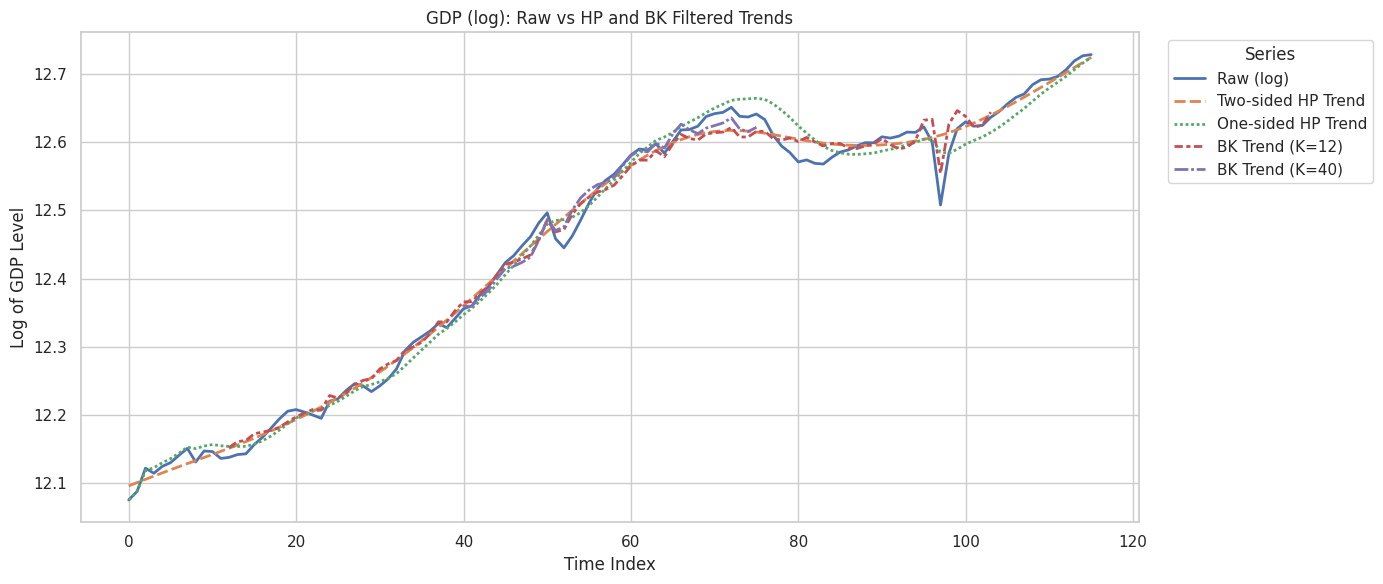

In [21]:
# --- Rename columns for consistent labeling ---
gdp_plot = gdp[["log_valor", "trend_two", "trend_one", "bk_trend", "bks_trend"]].copy()
gdp_plot.columns = [
    "Raw (log)",
    "Two-sided HP Trend",
    "One-sided HP Trend",
    "BK Trend (K=12)",
    "BK Trend (K=40)"
]

# --- Melt for Seaborn ---
gdp_plot = gdp_plot.reset_index().melt(
    id_vars="index",
    var_name="Series",
    value_name="Value"
)

# --- Plot ---
plt.figure(figsize=(14, 6))
sns.lineplot(
    data=gdp_plot,
    x="index",
    y="Value",
    hue="Series",
    style="Series",
    linewidth=2
)
plt.title("GDP (log): Raw vs HP and BK Filtered Trends")
plt.xlabel("Time Index")
plt.ylabel("Log of GDP Level")
plt.legend(title="Series", bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()


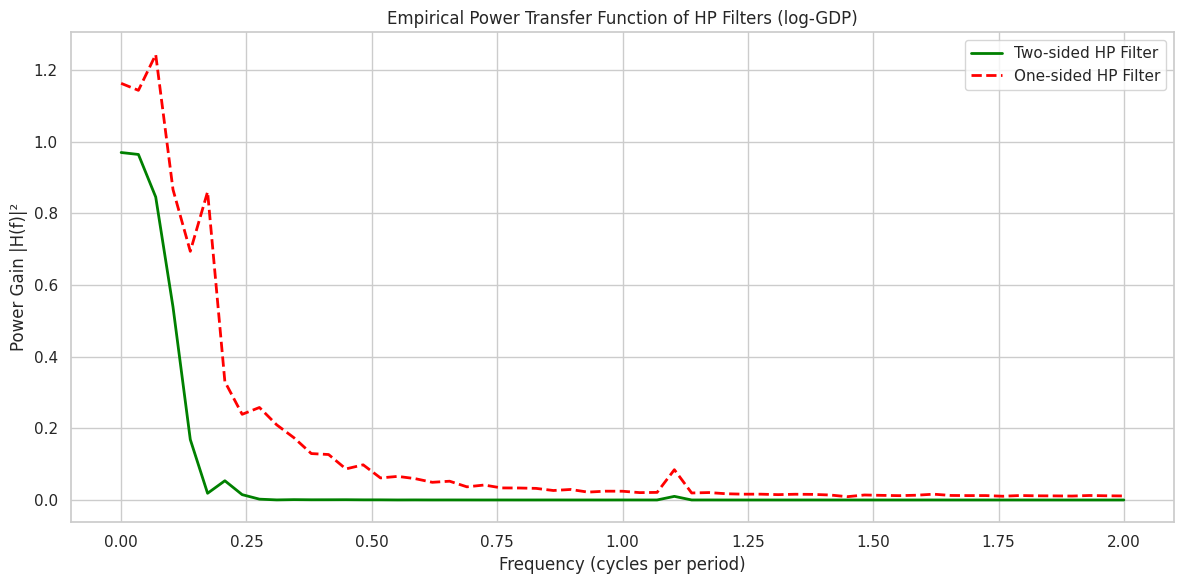

In [14]:
from scipy.signal import periodogram
import matplotlib.pyplot as plt
import numpy as np

# --- Input signal (log-GDP) ---
gdp_input = gdp["log_valor"].values

# --- Outputs from MATLAB HP filters ---
gdp_trend_two = gdp["trend_two"].values
gdp_trend_one = gdp["trend_one"].values

# --- Compute Power Spectral Densities (PSD) ---
freqs, psd_input = periodogram(gdp_input, fs=4, scaling='density', window='hann')
_, psd_two = periodogram(gdp_trend_two, fs=4, scaling='density', window='hann')
_, psd_one = periodogram(gdp_trend_one, fs=4, scaling='density', window='hann')

# --- Compute Empirical Power Transfer Functions ---
ptf_two = psd_two / psd_input
ptf_one = psd_one / psd_input

# Handle any numerical issues
ptf_two = np.nan_to_num(ptf_two)
ptf_one = np.nan_to_num(ptf_one)

cycle_length_years = freqs

# --- Plot ---
plt.figure(figsize=(12, 6))
plt.plot(cycle_length_years, ptf_two, label="Two-sided HP Filter", color='green', linewidth=2)
plt.plot(cycle_length_years, ptf_one, label="One-sided HP Filter", color='red', linestyle='--', linewidth=2)

plt.title("Empirical Power Transfer Function of HP Filters (log-GDP)")
plt.xlabel("Frequency (cycles per period)")
plt.ylabel("Power Gain |H(f)|²")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


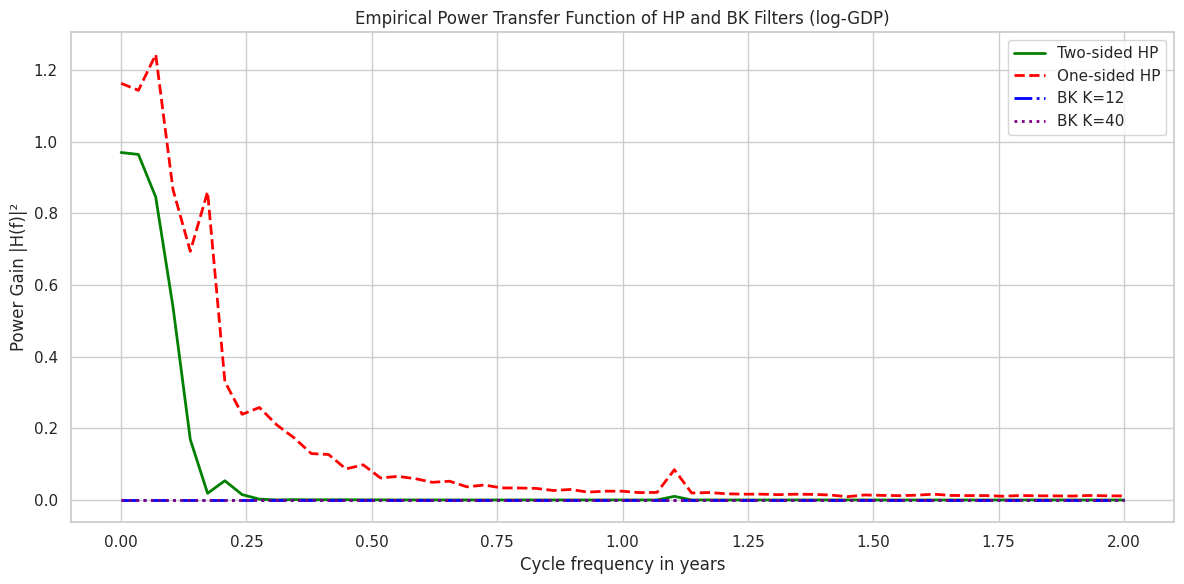

In [25]:
from scipy.signal import periodogram
import matplotlib.pyplot as plt
import numpy as np

# --- Input signal (log-GDP) ---
gdp_input = gdp["log_valor"].values
gdp_trend_two = gdp["trend_two"].values
gdp_trend_one = gdp["trend_one"].values
gdp_trend_bk12 = gdp["bk_trend"].values
gdp_trend_bk40 = gdp["bks_trend"].values

# --- Compute PSD with correct sampling frequency (quarterly = 4/year) ---
freqs, psd_input = periodogram(gdp_input, fs=4, scaling='density', window='hann')
_, psd_two = periodogram(gdp_trend_two, fs=4, scaling='density', window='hann')
_, psd_one = periodogram(gdp_trend_one, fs=4, scaling='density', window='hann')
_, psd_bk12 = periodogram(gdp_trend_bk12, fs=4, scaling='density', window='hann')
_, psd_bk40 = periodogram(gdp_trend_bk40, fs=4, scaling='density', window='hann')

# --- Compute Empirical Power Transfer Functions ---
ptf_two = np.nan_to_num(psd_two / psd_input)
ptf_one = np.nan_to_num(psd_one / psd_input)
ptf_bk12 = np.nan_to_num(psd_bk12 / psd_input)
ptf_bk40 = np.nan_to_num(psd_bk40 / psd_input)

# --- Convert frequency to cycle length in years ---
cycle_length_years = freqs

# --- Plot ---
plt.figure(figsize=(12, 6))
plt.plot(cycle_length_years, ptf_two, label="Two-sided HP", color='green', linewidth=2)
plt.plot(cycle_length_years, ptf_one, label="One-sided HP", color='red', linestyle='--', linewidth=2)
plt.plot(cycle_length_years, ptf_bk12, label="BK K=12", color='blue', linestyle='-.', linewidth=2)
plt.plot(cycle_length_years, ptf_bk40, label="BK K=40", color='purple', linestyle=':', linewidth=2)



plt.title("Empirical Power Transfer Function of HP and BK Filters (log-GDP)")
plt.xlabel("Cycle frequency in years")
plt.ylabel("Power Gain |H(f)|²")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


/tmp/ipykernel_19098/2762125446.py:20: RuntimeWarning: divide by zero encountered in divide
  cycle_length_years = 1 / freqs


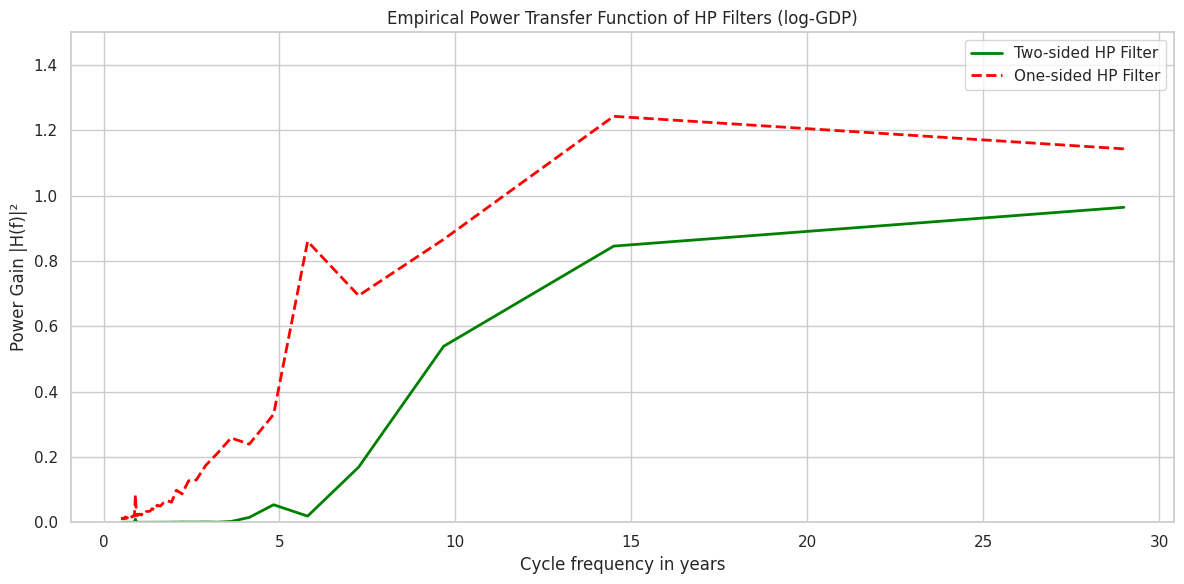

In [34]:
from scipy.signal import periodogram
import matplotlib.pyplot as plt
import numpy as np

# --- Input signal (log-GDP) ---
gdp_input = gdp["log_valor"].values
gdp_trend_two = gdp["trend_two"].values
gdp_trend_one = gdp["trend_one"].values

# --- Compute PSD with proper sampling frequency (quarterly = 4/year) ---
freqs, psd_input = periodogram(gdp_input, fs=4, scaling='density', window='hann')
_, psd_two = periodogram(gdp_trend_two, fs=4, scaling='density', window='hann')
_, psd_one = periodogram(gdp_trend_one, fs=4, scaling='density', window='hann')

# --- Compute Transfer Functions ---
ptf_two = np.nan_to_num(psd_two / psd_input)
ptf_one = np.nan_to_num(psd_one / psd_input)

# --- Convert frequency to cycle length in years ---
cycle_length_years = 1 / freqs

# Remove freq=0 to avoid inf values
valid = np.isfinite(cycle_length_years) & (cycle_length_years > 0)

# --- Plot ---
plt.figure(figsize=(12, 6))
plt.plot(cycle_length_years[valid], ptf_two[valid], label="Two-sided HP Filter", color='green', linewidth=2)
plt.plot(cycle_length_years[valid], ptf_one[valid], label="One-sided HP Filter", color='red', linestyle='--', linewidth=2)

#plt.xscale("log")
#plt.xlim(30, 0.5)  # Invert axis: left = long cycles
plt.ylim(0, 1.5)

plt.title("Empirical Power Transfer Function of HP Filters (log-GDP)")
plt.xlabel("Cycle frequency in years")
plt.ylabel("Power Gain |H(f)|²")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
